# Root finding

There are a number of papers on modelling the $I, V$ (current versus voltage) curve of a PV cell. A typical model has

\begin{equation}
  I = I_{\text{ph}} - I_0 \left[ \exp \left( \frac{V + I \times R_s}{a} - 1 \right) - 1 \right] - \frac{V + I \times R_s}{R_p}.
\end{equation}

The parameters $I_{\text{ph}}, I_0, a, R_s, R_p$ all need to be determined. To do this we'll need four pairs of $I, V$ values, determined by experiment. 

Even given those values the equation still can't be solved algebraically: it's nonlinear. Finding values that solve this equation is the realm of *nonlinear root finding*, and is crucial for a range of numerical methods.

# One dimensional case

Let's assume we know the values of three of the parameters,

\begin{equation}
  I_{\text{ph}} = 3.5, \quad I_0 = 3.2, \quad a = 20, \quad R_p = 300.
\end{equation}

We'll also assume that a voltage $V = 10$ gives a current $I = 3$. So we have to solve the equation

\begin{align}
  f(R_s) &= I_{\text{ph}} - I_0 \left[ \exp \left( \frac{V + I \times R_s}{a} - 1 \right) - 1 \right] - \frac{V + I \times R_s}{R_p} - I \\
  &= 3.5 - 3.2 \left[ \exp \left( \frac{10 + 3 R_s}{20} - 1 \right) - 1 \right] - \frac{10 + 3 R_s}{300} - 3\\
  &= 0.
\end{align}

Where this equation is satisfied we have the value of $R_s$.

Let's check that there is a solution, by plotting values of $f$ for different possible values of $R_s$:

In [10]:
from __future__ import division
import numpy
from matplotlib import pyplot
%matplotlib notebook

<IPython.core.display.Javascript object>


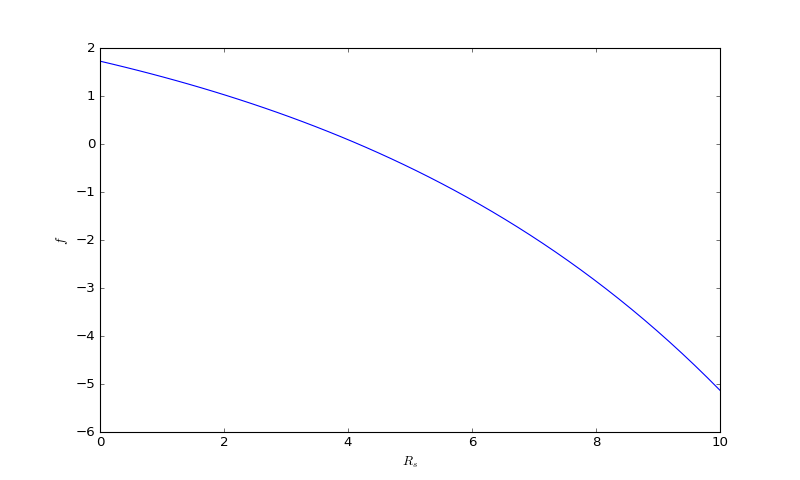

In [12]:
def f(Rs):
    return 3.5 -3.2*(numpy.exp((10+3*Rs)/20.0 - 1.0) - 1.0) - (10.0 + 3.0*Rs)/300.0 - 3

Rs = numpy.linspace(0, 10)
pyplot.figure(figsize=(10,6))
pyplot.plot(Rs, f(Rs))
pyplot.xlabel(r"$R_s$")
pyplot.ylabel(r"$f$")
pyplot.show()

We see that there is a solution at around $R_s = 4$. We want to find it precisely.

## Bisection

It's clear from the figure that there's a solution in the middle: the curve is continuous, and has different signs at either end.

In [14]:
print("When Rs=0, f(Rs)={}".format(f(0)))
print("When Rs=10, f(Rs)={}".format(f(10)))

When Rs=0, f(Rs)=1.72576855559
When Rs=10, f(Rs)=-5.1318351844


We could pick the point in the middle, where $R_s=5$, and check its value:

In [15]:
print("When Rs=5, f(Rs)={}".format(f(5)))

When Rs=5, f(Rs)=-0.492214666734


So the sign of $f$ changes between $0$ and $5$ (as expected):

<IPython.core.display.Javascript object>


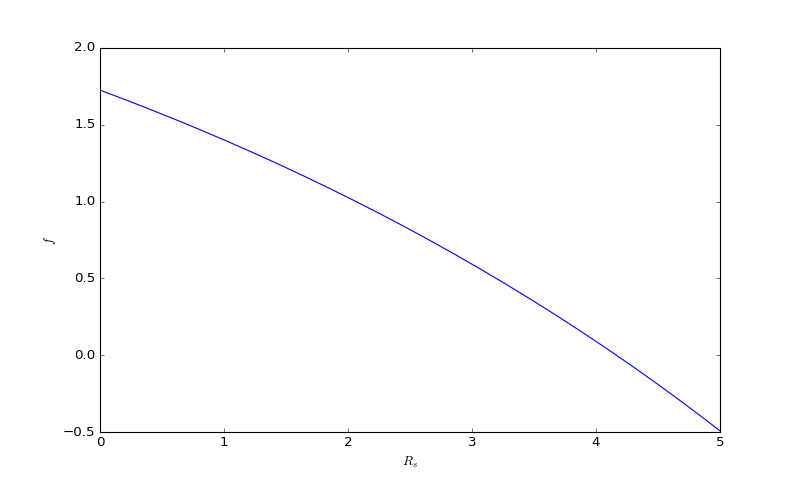

In [17]:
pyplot.figure(figsize=(10,6))
pyplot.plot(Rs, f(Rs))
pyplot.xlim(0, 5)
pyplot.ylim(-0.5, 2)
pyplot.xlabel(r"$R_s$")
pyplot.ylabel(r"$f$")
pyplot.show()

This suggests an algorithm - the *bisection* algorithm.

1. Pick $R_s^{\text{L}}$ and $R_s^{\text{R}}$ such that $f(R_s^{\text{L}}) \times f(R_s^{\text{R}}) < 0$.
2. Compute the midpoint $R_s^{\text{M}} = \tfrac{1}{2}(R_s^{\text{L}} + R_s^{\text{R}})$.
3. Compute the function $f(R_s^{\text{M}})$.
   1. If $f(R_s^{\text{L}}) \times f(R_s^{\text{M}}) < 0$ then the root is between the left point and the midpoint. So set $R_s^{\text{R}} = R_s^{\text{M}}$.
   2. Otherwise the root is between the midpoint and the right point. So set $R_s^{\text{L}} = R_s^{\text{M}}$.
4. Repeat from 2 until the value of $f(R_s^{\text{M}})$ is sufficiently small.

Let's implement that, requiring that $| f(R_s^{\text{M}}) | < 10^{-12}$.

In [19]:
RsL = 0
RsR = 10
fL = f(RsL)
fR = f(RsR)
max_iterations = 100
tolerance = 1e-12
fM = 1
iteration = 0
while (abs(fM) > tolerance) and (iteration < max_iterations):
    iteration += 1
    RsM = 0.5*(RsL + RsR)
    fM = f(RsM)
    if fL*fM < 0:
        RsR = RsM
        fR = fM
    else:
        RsL = RsM
        fL = fM
print("Determined Rs={}, with f(Rs)={}, after {} iterations".format(RsM, fM, iteration))

Determined Rs=4.16472555518, with f(Rs)=3.79252185212e-13, after 41 iterations


## Newton's method

Bisection is safe - it will always converge. It has two problems. The first is that it's slow: requiring tens or hundreds of function evaluations (which could be expensive) to find the root. The second is that it's very difficult to generalize to multiple dimensions.

Instead we use Newton's method. This starts from a guess for $R_s$, $R_s^{(0)}$. It then updates this guess, computing

\begin{equation}
  R_s^{(k+1)} = R_s^{(k)} - \frac{f \left( R_s^{(k)} \right)}{f' \left( R_s^{(k)} \right)}.
\end{equation}

This is computing the tangent to the curve $f(R_s)$ at the guess $R_s^{(k)}$. It then moves along a straight line with this slope until it intersects the horizontal axis: that becomes our new guess.

Newton's method is *much* faster. Its disadvantages are that it isn't safe - it's not guaranteed to converge - and there's the additional effort of computing the derivative.

Let's check how fast it is, starting from a guess of 5:

In [20]:
def df(Rs):
    return -3.2*3/20.0*numpy.exp((10+3*Rs)/20.0 - 1.0) -  3.0/300.0

In [21]:
Rs_guess = 5
f_guess = f(Rs_guess)
iteration = 0
while (abs(f_guess) > tolerance) and (iteration < max_iterations):
    iteration += 1
    df_guess = df(Rs_guess)
    Rs_guess = Rs_guess - f_guess / df_guess
    f_guess = f(Rs_guess)
print("Determined Rs={}, with f(Rs)={}, after {} iterations".format(Rs_guess, f_guess, iteration))

Determined Rs=4.16472555518, with f(Rs)=-4.4408920985e-16, after 4 iterations


The huge improvement in speed is extremely important when solving complex problems. However, the choice of initial guess is crucial to the method converging to the right answer (or at all!).

# Multi-dimensional case